# Прогнозирование заказов такси

## Описание проекта

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. 

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.


### Описание данных

Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце '*num_orders*' (от англ. *number of orders*, «число заказов»).

#### Часть 1. [Подготовка данных](#part1)
* [1. Импорт библиотек.](#part1.1)
* [2. Загрузка и подготовка данных](#part1.2)

#### Часть 2. [Анализ](#part2)
* [2.1 Скользящее среднее](#part2.1)
* [2.2 Тренды и сезонность](#part2.2)

#### Часть 3. [Обучение моделей](#part3)
* [3.1 Добавление признаков](#part3.1)
* [3.2 Разделение на выборки](#part3.2)
* [3.3 Линейная регрессия](#part3.3)
* [3.4 Случайный лес](#part3.4)
* [3.5 Решающее дерево](#part3.5)
* [3.6 Градиентный бустинг](#part3.6)

#### Часть 4. [Тестирование](#part4)

#### Часть 5. [Общий вывод](#part5)

<a id='part1'></a>
# 1. Подготовка
<a id='part1.1'></a>
## 1.1 Импорт библиотек

In [1]:
#
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as plt_dates
import seaborn as sns
#
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV, TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose

#модели
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
import lightgbm as lgb

<a id='part1.2'></a>
## 1.2 Загрузка и подготовка данных

In [2]:
data = pd.read_csv('datasets/taxi.csv', index_col=[0], parse_dates=[0])
data.sort_index(inplace=True)
data = data.resample('1H').sum()

data.info()
data.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB


,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


## Вывод

Данные загружены и подготовлены. Произведено ресемплирование по часу, в качестве индексов в датафрейме выделены значения даты и времени.

<a id='part2'></a>
# 2. Анализ
<a id='part2.1'></a>
## 2.1 Скользящее среднее

Изучим данные за две недели с 2018-04-02 (Понедельник) по 2018-04-16.

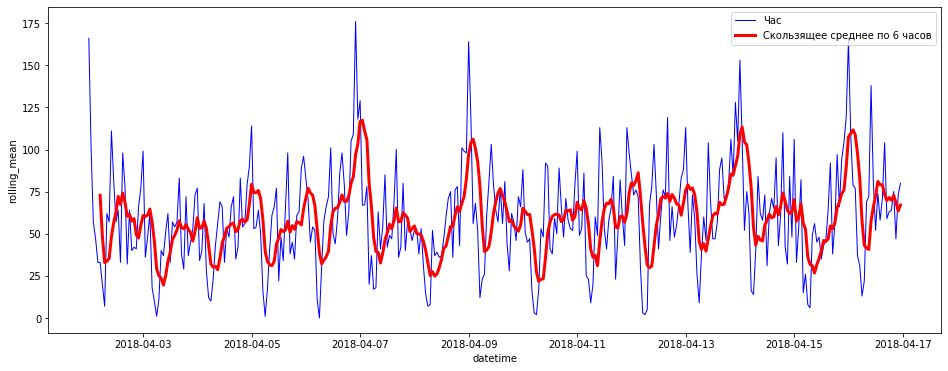

In [3]:
data_2m = data['2018-04-02':'2018-04-16'].resample('1H').sum()
data_1d = data.resample('1D').sum()

data_2m['rolling_mean'] = data_2m.rolling(6).mean()

fig, ax = plt.subplots(figsize=(16,6))

sns.lineplot(ax=ax,x = data_2m.index, y = data_2m['num_orders'],color='b', lw=1, label = 'Час')
sns.lineplot(ax=ax,x = data_2m.index, y = data_2m['rolling_mean'], color='r', lw=3, label = 'Скользящее среднее по 6 часов')

In [4]:
b = ax.get_xticklabels()
display(b)

<a list of 8 Text xticklabel objects>

За две недели такси вызывалось более или менее равномерно с четко прослеживающимися пиками вечером и по выходным.

<a id='part2.2'></a>
## 2.1 Тренды и сезонность

Рассмотрим  общий тренд, сезонные составляющие и остатки.

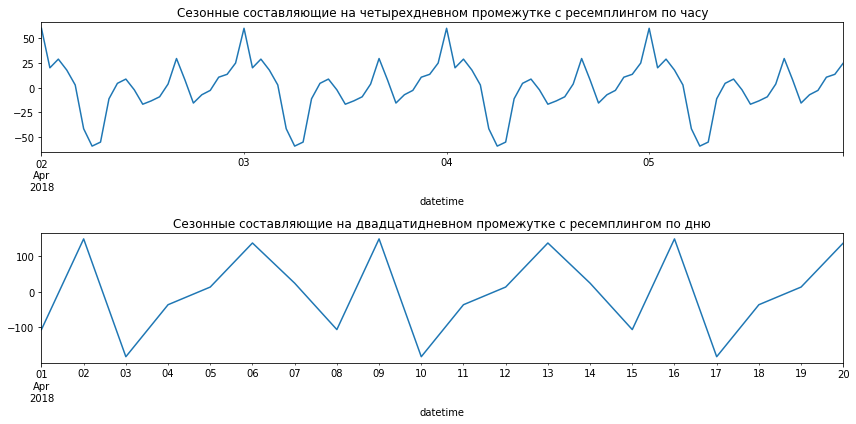

In [5]:
plt.subplot(211)
decomposed = seasonal_decompose(data)
decomposed.seasonal['2018-04-02':'2018-04-05'].plot(figsize=(12,6))
plt.title('Сезонные составляющие на четырехдневном промежутке с ресемплингом по часу')

plt.subplot(212)
decomposed2 = seasonal_decompose(data_1d)
decomposed2.seasonal['2018-04-01':'2018-04-20'].plot(figsize=(12,6))
plt.title('Сезонные составляющие на двадцатидневном промежутке с ресемплингом по дню')
plt.tight_layout()

Сезонные составляющие очень четко показывают, как такси вызывается каждый день: спад ночью, небольшой пик утром, пик в обед и сильный всплеск вечером.  
Также сезонность прослеживается при ресемплинге суммой за день. По вторникам и воскресеньям такси заказывается меньше, чем в остальные дни.

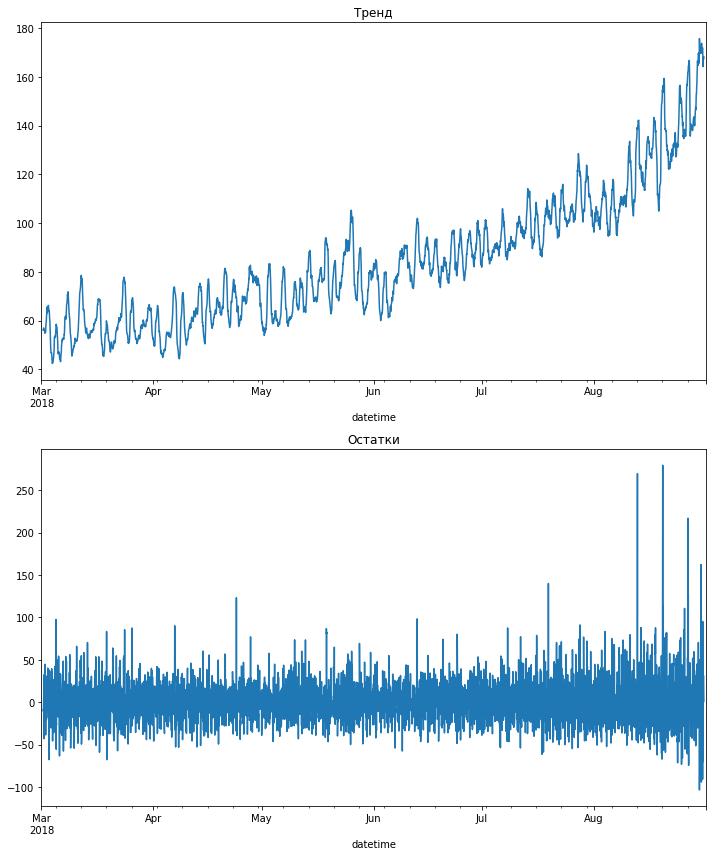

In [6]:
plt.figure(figsize=(10, 12))
plt.subplot(211)
decomposed.trend.plot(ax=plt.gca())
plt.title('Тренд')

plt.subplot(212)
decomposed.resid.plot(ax=plt.gca())
plt.title('Остатки')
plt.tight_layout()

Тренд по всем данным показывает, что каждый месяц количество вызываемого такси увеличивалось. Возможно, это связано с сезонностью и летом такси вызывается больше, чем зимой, но данных недостаточно, чтобы это утверждать.

Остатки декомпозиции показывают, что шумы равномерны с редкими всплесками , которые могли быть вызваны чем угодно (праздничные дни?)

<a id='part3'></a>
# 3. Обучение
<a id='part3.1'></a>
## 3.1 Добавление признаков

Изучаемые данные охватывают полгода: 2018-03-01 00:00:00 - 2018-08-31 23:00:00.
Добавим следующие признаки: 
    * Календарные: месяц, число, день недели и час
    * Остающие значения (выберем 6 часов)
    * Скользящее среднее (окно - 6 часов)

In [7]:
def make_features(data, max_lag, rolling_mean_size):
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)
        data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()
        
make_features(data, 6, 6)
print(data.head())

                     num_orders  month  day  dayofweek  hour  lag_1  \
datetime                                                              
2018-03-01 00:00:00         124      3    1          3     0    NaN   
2018-03-01 01:00:00          85      3    1          3     1  124.0   
2018-03-01 02:00:00          71      3    1          3     2   85.0   
2018-03-01 03:00:00          66      3    1          3     3   71.0   
2018-03-01 04:00:00          43      3    1          3     4   66.0   

                     rolling_mean  lag_2  lag_3  lag_4  lag_5  lag_6  
datetime                                                              
2018-03-01 00:00:00           NaN    NaN    NaN    NaN    NaN    NaN  
2018-03-01 01:00:00           NaN    NaN    NaN    NaN    NaN    NaN  
2018-03-01 02:00:00           NaN  124.0    NaN    NaN    NaN    NaN  
2018-03-01 03:00:00           NaN   85.0  124.0    NaN    NaN    NaN  
2018-03-01 04:00:00           NaN   71.0   85.0  124.0    NaN    NaN  


<a id='part3.2'></a>
## 3.2 Разделение на выборки

Выделим тестовую выборку размером 10% и выделим в полученных выборках целевой признак.

In [8]:
train, test = train_test_split(data, shuffle=False, test_size=0.1, random_state=1)
train = train.dropna()


y_train = train.num_orders
X_train = train.drop('num_orders', axis=1)

y_test = test.num_orders
X_test = test.drop('num_orders', axis=1)

# для кросс-валидации разбиваем на 5 частей
time_split = TimeSeriesSplit(n_splits=5)

<a id='part3.3'></a>
## 3.3 Линейная регрессия

In [9]:
model=[None]*4
model[0] = LinearRegression()
model[0].fit(X_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

<a id='part3.4'></a>
## 3.4 Случайный лес

Ищем оптимальные параметры с помощью RanodmizedSearchCV, используя TimeSeriesSplit.

In [10]:
%%script false --no-raise-error
#пропуск выполнения ячейки

model_rf = RandomForestRegressor(random_state=1)
model_params = {
 
    'max_depth': [i for i in range(1,80)],
    'min_samples_split' : [i for i in range(2,80)],
    'min_samples_leaf' : [i for i in range(2,80)],
    'n_estimators' : [i for i in range(10,160,10)]
}

rs_rf = RandomizedSearchCV(model_rf, model_params, scoring='neg_root_mean_squared_error', cv=time_split,
                           n_jobs=-1,n_iter=500,random_state=1)

search_rs_rf = rs_rf.fit(X_train,y_train)
print('Лучшие гиперпараметры:')
print(search_rs_rf.best_estimator_)
print('Лучший RMSE:')
print(search_rs_rf.best_score_)

Couldn't find program: 'false'


##### Вывод ячейки

Лучшие гиперпараметры:  
RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',  
                      max_depth=47, max_features='auto', max_leaf_nodes=None,  
                      max_samples=None, min_impurity_decrease=0.0,  
                      min_impurity_split=None, min_samples_leaf=3,  
                      min_samples_split=6, min_weight_fraction_leaf=0.0,  
                      n_estimators=50, n_jobs=None, oob_score=False,  
                      random_state=1, verbose=0, warm_start=False)  
Лучший RMSE:  
-25.427146414205225  

Обучаем модель

In [11]:
model[1] = RandomForestRegressor(random_state=1,
 
    max_depth=47,
    min_samples_split=6,
    min_samples_leaf=3,
    n_estimators=50
)

model[1].fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=47, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=3,
                      min_samples_split=6, min_weight_fraction_leaf=0.0,
                      n_estimators=50, n_jobs=None, oob_score=False,
                      random_state=1, verbose=0, warm_start=False)

<a id='part3.5'></a>
## 3.5 Решающее дерево

Ищем оптимальные параметры с помощью RanodmizedSearchCV, используя TimeSeriesSplit.

In [12]:
%%script false --no-raise-error
#пропуск выполнения ячейки

model_dt = DecisionTreeRegressor(random_state=1)

model_params = {
 
    'max_depth': [i for i in range(1,30)],
    'min_samples_split' : [i for i in range(2,30)],
    'min_samples_leaf' : [i for i in range(1,30)],
}

rs_dt = RandomizedSearchCV(model_dt, model_params, scoring='neg_root_mean_squared_error', 
                           cv=time_split, n_jobs=-1, n_iter=500)
search_rs_dt = rs_dt.fit(X_train,y_train)
print('Лучшие гиперпараметры:')
print(search_rs_dt.best_estimator_)
print('Лучший RMSE:')
print(search_rs_dt.best_score_)

Couldn't find program: 'false'


##### Вывод ячейки

Лучшие гиперпараметры:  
DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=15,  
                      max_features=None, max_leaf_nodes=None,  
                      min_impurity_decrease=0.0, min_impurity_split=None,  
                      min_samples_leaf=12, min_samples_split=28,  
                      min_weight_fraction_leaf=0.0, presort='deprecated',  
                      random_state=1, splitter='best')  
Лучший RMSE:  
-27.10377156221905  

Обучаем модель

In [13]:
model[2] = DecisionTreeRegressor(random_state=1,
                                max_depth=23,
                                min_samples_split=28,
                                min_samples_leaf=12)

model[2].fit(X_train, y_train)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=23,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=12, min_samples_split=28,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=1, splitter='best')

<a id='part3.6'></a>
## 3.6 Градиентый бустинг

Ищем оптимальные параметры с помощью RanodmizedSearchCV, используя TimeSeriesSplit.

In [14]:
%%script false --no-raise-error
#пропуск выполнения ячейки

model_gb = lgb.LGBMRegressor(silent=True)
                         
param_dist = {'num_leaves': [10,30,50,100,300,600],
             'max_depth' : [15,25,35,45,55,65],
             'learning_rate' : [0.01,0.05,0.1,0.3],
             'min_child_weight': [1e-1, 1, 1e1],
             'subsample': [0.6,0.7,0.8,0.9,0.93,0.98], 
             'colsample_bytree': [0.6,0.7,0.8,0.9,0.93,0.95],
             'reg_alpha': [0, 1e-1, 1, 5, 10, 50, 70, 100],
             'reg_lambda': [0, 1e-1, 1, 5, 10, 50],
             'n_estimators' : [500]
             }

rs_gb = RandomizedSearchCV(
    estimator=model_gb, 
    param_distributions=param_dist, 
    scoring='neg_root_mean_squared_error',
    n_iter=500,
    cv=time_split,
    n_jobs=4
    )

search_rs_gb = rs_gb.fit(X_train,y_train)
print('Лучшие гиперпараметры:')
print(search_rs_gb.best_estimator_)
print('Лучший RMSE:')
print(search_rs_gb.best_score_)

Couldn't find program: 'false'


##### Вывод ячейки  

Лучшие гиперпараметры:  
LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=0.6,  
              importance_type='split', learning_rate=0.05, max_depth=15,  
              min_child_samples=20, min_child_weight=1, min_split_gain=0.0,  
              n_estimators=500, n_jobs=-1, num_leaves=10, objective=None,  
              random_state=None, reg_alpha=70, reg_lambda=0.1, silent=True,  
              subsample=0.9, subsample_for_bin=200000, subsample_freq=0)  
Лучший RMSE:  
-25.08094544113583  

Обучаем модель

In [15]:
model[3] = lgb.LGBMRegressor(silent=True, n_jobs=-1, n_estimators=700, learning_rate=0.01, colsample_bytree=0.7, 
                             max_depth=45, min_child_weight=0.1, num_leaves=30,  reg_alpha=70, reg_lambda=0,
                             subsample=0.93)

model[3].fit(X_train, y_train)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=0.7,
              importance_type='split', learning_rate=0.01, max_depth=45,
              min_child_samples=20, min_child_weight=0.1, min_split_gain=0.0,
              n_estimators=700, n_jobs=-1, num_leaves=30, objective=None,
              random_state=None, reg_alpha=70, reg_lambda=0, silent=True,
              subsample=0.93, subsample_for_bin=200000, subsample_freq=0)

## Вывод

Добвлены признаки (календарные: месяц, число, день недели и час, остающие значения (выберем 6 часов) и скользящее среднее (окно - 6 часов).  
Данны разбиты на обучающую и тестовую выборки.  
Подобраны оптимальные гиперпараметры для моделей. Модели обучены на тренировочных данных.

<a id='part4'></a>
# 4. Тестирование

In [16]:
predicted = [None]*4
#i=1
for i in range(len(model)):
    predicted = model[i].predict(X_test)
    if i==0:
        name='линейной регрессии'
    if i==1:
        name='случайного леса'
    if i==2:
        name='решающего дерева'
    if i==3:
        name='градиентного бустинга'
    print("RMSE {}: {:.2f}".format(name,mean_squared_error(y_test,predicted)**0.5)) 

RMSE линейной регрессии: 52.96
RMSE случайного леса: 44.60
RMSE решающего дерева: 47.89
RMSE градиентного бустинга: 44.16


## Вывод

||Линейная регрессия|Модель решашающего дерева|Модель случайного леса|Градиентный бустинг|
|-|-|-|-|-|
| RMSE на тестовых данных|52.96|47.89|44.6|44.16|

Все модели, кроме линейной регрессии выдают значение RMSE на тестовой выборке менее 48.   
Лучшее значение у модели градиентного бустинга.

<a id='part5'></a>
# 5. Общий вывод

В результате работы были изучены и подготовлены исторические данные о заказах такси в аэропортах.
Произведено ресемплирование по часу, заменены индексы.

Данные были проанализированы, выявлена ежедневная сезонная составляющая.

Было обучено четыре модели (линейная регрессия, решающее дерево, случайный лес, градиентный бустинг) и методом случайного поиска были подобраны оптимальные гипермапараметры.

Все обученные модели были поверены на тестовой выборке. Самым лучшим качеством (RMSE=44.16) обладает модель градиентного бустинга.